In [229]:
import timeseries as ts
from my_utils import *
from glob import glob
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# plotly modules
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import Model, load_model

from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from tensorflow.math import divide, multiply

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import eli5
from eli5.sklearn import PermutationImportance

In [230]:
# hyperparameters

modelName = "ann-model"

validation_split = 0.1
test_size = 0.15
batch_size = 32

epochSize = 150

# trainModel = True
trainModel = False

# dropout = True
dropout = False


In [231]:
# reading dataset
dataset = glob("dataset/*")[0]
df = pd.read_csv(dataset, decimal=',')

#numerical features
float_features = list(df.drop(["tarih", "saat","gun"], axis=1).columns) 
df.loc[:, float_features] = df.loc[:, float_features].astype(float)
print("shape of numerical features", df.loc[:, float_features].shape)

shape of numerical features (25310, 24)


In [232]:
# removing abnormal data
df = df[df.tarih != "21/12/2016"]
df = df[df.tarih != "22/12/2016"]
df = df[df.tarih != "10/09/2017"]

In [233]:
df.head()

,tarih,saat,ptf,gun,ay,yil,ptf_l1,ptf_l23,ptf_l24,ptf_l48,...,smf_l144,yuk_tahmin_l144,yuk_tahmin_l24,yuk_gercek_l24,yuk_gercek_l144,ankaraT_n24,istanbulT_n24,gunS,saatS,sicaklik_ort
0,18/01/2016,00:00,119.99,Sali,1.0,2016.0,115.52,117.14,119.99,120.00,...,95.00,29000.0,27700.0,28125.56,29161.64,8.0,12.0,2.0,0.0,10.00
1,18/01/2016,01:00,119.99,Sali,1.0,2016.0,119.99,10.01,117.14,119.99,...,94.00,27400.0,25900.0,26344.08,27519.24,8.1,12.0,2.0,1.0,10.05
2,18/01/2016,02:00,10.01,Sali,1.0,2016.0,119.99,0.13,10.01,79.99,...,94.00,26100.0,25000.0,25233.20,26256.43,7.2,12.0,2.0,2.0,9.60
3,18/01/2016,03:00,0.57,Sali,1.0,2016.0,10.01,0.00,0.13,0.94,...,88.73,25600.0,24500.0,24526.40,25766.11,7.0,12.0,2.0,3.0,9.50
4,18/01/2016,04:00,0.34,Sali,1.0,2016.0,0.57,0.00,0.00,0.32,...,69.04,25700.0,24300.0,24131.34,25808.92,6.4,12.0,2.0,4.0,9.20


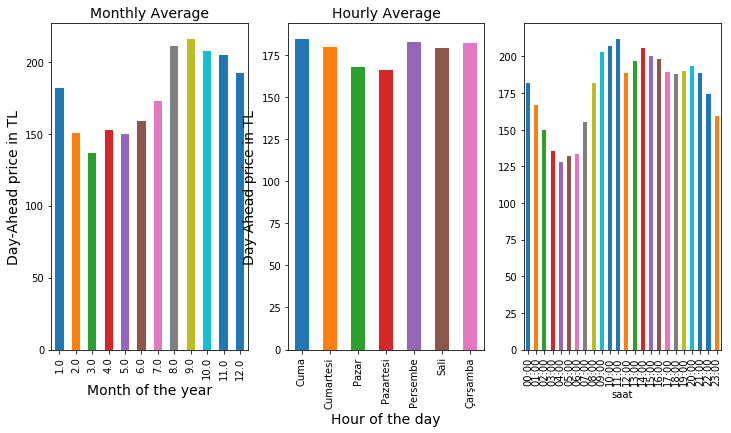

In [234]:
ts.plot_average_prices(df)

In [235]:
# replace outliers by outlier threshold
df = ts.replace_outliers(df, 'ptf', 3)

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25238 entries, 0 to 25309
Data columns (total 27 columns):
tarih              25238 non-null object
saat               25238 non-null object
ptf                25238 non-null float64
gun                25238 non-null object
ay                 25238 non-null float64
yil                25238 non-null float64
ptf_l1             25238 non-null float64
ptf_l23            25238 non-null float64
ptf_l24            25238 non-null float64
ptf_l48            25238 non-null float64
ptf_l72            25238 non-null float64
ptf_l144           25238 non-null float64
ptf_l168           25238 non-null float64
ptf_l312           25238 non-null float64
ptf_l336           25238 non-null float64
ptf_n24            25238 non-null float64
smf_l24            25238 non-null float64
smf_l144           25238 non-null float64
yuk_tahmin_l144    25238 non-null float64
yuk_tahmin_l24     25238 non-null float64
yuk_gercek_l24     25238 non-null float64
yuk_gercek_l

In [237]:
df.head()

,tarih,saat,ptf,gun,ay,yil,ptf_l1,ptf_l23,ptf_l24,ptf_l48,...,smf_l144,yuk_tahmin_l144,yuk_tahmin_l24,yuk_gercek_l24,yuk_gercek_l144,ankaraT_n24,istanbulT_n24,gunS,saatS,sicaklik_ort
0,18/01/2016,00:00,119.99,Sali,1.0,2016.0,115.52,117.14,119.99,120.00,...,95.00,29000.0,27700.0,28125.56,29161.64,8.0,12.0,2.0,0.0,10.00
1,18/01/2016,01:00,119.99,Sali,1.0,2016.0,119.99,10.01,117.14,119.99,...,94.00,27400.0,25900.0,26344.08,27519.24,8.1,12.0,2.0,1.0,10.05
2,18/01/2016,02:00,10.01,Sali,1.0,2016.0,119.99,0.13,10.01,79.99,...,94.00,26100.0,25000.0,25233.20,26256.43,7.2,12.0,2.0,2.0,9.60
3,18/01/2016,03:00,0.57,Sali,1.0,2016.0,10.01,0.00,0.13,0.94,...,88.73,25600.0,24500.0,24526.40,25766.11,7.0,12.0,2.0,3.0,9.50
4,18/01/2016,04:00,0.34,Sali,1.0,2016.0,0.57,0.00,0.00,0.32,...,69.04,25700.0,24300.0,24131.34,25808.92,6.4,12.0,2.0,4.0,9.20


In [238]:
df.tail()

,tarih,saat,ptf,gun,ay,yil,ptf_l1,ptf_l23,ptf_l24,ptf_l48,...,smf_l144,yuk_tahmin_l144,yuk_tahmin_l24,yuk_gercek_l24,yuk_gercek_l144,ankaraT_n24,istanbulT_n24,gunS,saatS,sicaklik_ort
25305,06/12/2018,19:00,285.44,Cuma,12.0,2018.0,290.47,299.22,174.00,302.21,...,274.88,37300.0,38300.0,38020.11,37940.11,9.5,27.0,5.0,19.0,18.25
25306,06/12/2018,20:00,286.24,Cuma,12.0,2018.0,285.44,303.18,299.22,300.37,...,196.18,36600.0,37400.0,37359.11,36999.68,9.3,27.0,5.0,20.0,18.15
25307,06/12/2018,21:00,284.50,Cuma,12.0,2018.0,286.24,280.98,303.18,299.22,...,196.18,35700.0,36200.0,36428.37,36031.98,9.1,27.0,5.0,21.0,18.05
25308,06/12/2018,22:00,271.99,Cuma,12.0,2018.0,284.50,173.99,280.98,264.34,...,190.00,34800.0,35600.0,35394.00,35224.00,8.5,27.0,5.0,22.0,17.75
25309,06/12/2018,23:00,251.62,Cuma,12.0,2018.0,271.99,280.20,173.99,262.90,...,222.18,33700.0,33900.0,33716.75,33752.94,8.4,27.0,5.0,23.0,17.70


In [239]:
# scaling dataset
scaler = MinMaxScaler()
float_features.remove('ptf_n24')
df.loc[:, float_features] = scaler.fit_transform(df.loc[:, float_features].values)

ptf_n24_scaler = MinMaxScaler()
df.ptf_n24 = ptf_n24_scaler.fit_transform(np.array(df.ptf_n24).reshape(-1, 1))


In [240]:
# splitting dataset as train and test 
X = df.loc[:, float_features]
Y = df.ptf_n24

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=10)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [241]:
print("shape of X:", X.shape)
print("shape of Y:", Y.shape)

shape of X: (25238, 23)
shape of Y: (25238,)


In [242]:
inpt_length = len(float_features)

def ann_model1(dropout=False):
    model = Sequential()
    model.add(Dense(128,activation='relu',input_dim=inpt_length))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam",  metrics=["mse"])
    return model

def ann_model2(dropout=False):
    model = Sequential()
    model.add(Dense(64,activation='relu',input_dim=inpt_length))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam",  metrics=["mse"])
    return model

# selecting model
model = ann_model1

In [243]:
sk_params = {
        "validation_split": validation_split,
        "epochs":epochSize,
        "batch_size": batch_size,
        "verbose":2,
}
sk_params_ = {
        "validation_split":validation_split,
        "epochs":epochSize,
        "batch_size":batch_size,
        "verbose":2,
        "callbacks":[
            TrainValTensorBoard(log_dir='./TensorBoardGraph', write_graph=True),
#             EarlyStopping(monitor='val_loss', patience=5, verbose=2),
            ModelCheckpoint('checkpoints/'+modelName, monitor='val_loss', save_best_only=True, verbose=0)]
}

# creating model
model = KerasRegressor(build_fn=model, **sk_params)
if trainModel == True:
    # train model
    model.fit(X_train, y_train, **sk_params_ )
    
    # serialize model to JSON
    model_json = model.model.to_json()
    with open("models/"+modelName+".json", "w") as json_file:
        json_file.write(model_json)
        
    # serialize weights to HDF5
    model.model.save_weights("models/"+modelName+".h5")
    print("Saved model to disk")
else:
    # load model from json 
    json_file = open("models/"+modelName+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model.model = model_from_json(loaded_model_json)
    
    # load weights into new model
    model.model.load_weights("models/"+modelName+'.h5')
    model.model.compile(loss="mean_squared_error", optimizer="adam",  metrics=["mse"])
    print("Model loaded")

Model loaded


In [244]:
# showing feature importance
perm = PermutationImportance(model).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.0061 ± 0.0001,x0
0.0052 ± 0.0001,x2
0.0024 ± 0.0001,x1
0.0019 ± 0.0001,x20
0.0014 ± 0.0000,x19
0.0012 ± 0.0000,x21
0.0010 ± 0.0000,x17
0.0010 ± 0.0000,x18
0.0009 ± 0.0000,x10
0.0009 ± 0.0000,x15


In [245]:
# printing features
for a,b in zip(list(range(len(float_features))), list(X.columns.values)):
    print ('x'+str(a)+ " -> "+b+"\n", end='')

x0 -> ptf
x1 -> ay
x2 -> yil
x3 -> ptf_l1
x4 -> ptf_l23
x5 -> ptf_l24
x6 -> ptf_l48
x7 -> ptf_l72
x8 -> ptf_l144
x9 -> ptf_l168
x10 -> ptf_l312
x11 -> ptf_l336
x12 -> smf_l24
x13 -> smf_l144
x14 -> yuk_tahmin_l144
x15 -> yuk_tahmin_l24
x16 -> yuk_gercek_l24
x17 -> yuk_gercek_l144
x18 -> ankaraT_n24
x19 -> istanbulT_n24
x20 -> gunS
x21 -> saatS
x22 -> sicaklik_ort


In [246]:
# predicting train and test dataset
trainPred = model.predict(X_train)
testPred = model.predict(X_test)

trainPred = ptf_n24_scaler.inverse_transform(np.array(trainPred).reshape(-1, 1))
testPred  = ptf_n24_scaler.inverse_transform(np.array(testPred).reshape(-1, 1) )

# reversing scaled dataset
X_train = scaler.inverse_transform(X_train)
X_test = scaler.inverse_transform(X_test)

y_train= ptf_n24_scaler.inverse_transform(y_train)
y_test= ptf_n24_scaler.inverse_transform(y_test)

In [247]:
# calculating R2 scores
train_r2_score = r2_score(y_train, trainPred)
test_r2_score = r2_score(y_test, testPred)
print("Train r2_score: ", train_r2_score)
print("Test r2_score: ", test_r2_score)

# calculating RMSE scores
trainRmse = math.sqrt(mean_squared_error( trainPred, y_train ))
print('Train Score: %.5f RMSE' % (trainRmse))
testRmse = math.sqrt(mean_squared_error(testPred, y_test))
print('Test Score: %.5f RMSE' % (testRmse))


Train r2_score:  0.9079621406243497
Test r2_score:  0.8706060734137501
Train Score: 20.98138 RMSE
Test Score: 24.87018 RMSE


In [ ]:
# predicting the whole dataset
y_pred = model.predict(X)
y_pred = ptf_n24_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_true = ptf_n24_scaler.inverse_transform(np.array(Y).reshape(-1, 1))

# plotting predictions of the whole dataset and saving to file 
trace1 = go.Scatter(
                    x = list(range(y_true.reshape(-1).shape[0])),
                    y = y_true.reshape(-1),
                    mode = "lines+markers",
                    name = "real",
                    marker = dict(color = 'red'),
)
trace2 = go.Scatter(
                    x = list(range(y_pred.reshape(-1).shape[0])),
                    y = y_pred.reshape(-1),
                    mode = "lines",
                    name = "prediction",
                    marker = dict(color = 'green'),
                    text = df.tarih + " " + df.saat + " " + df.gun
)
data = [trace1, trace2]
layout = dict(title = 'day-ahead (ptf) prices predictions',
              xaxis= dict(title= 'time',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'price',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
plot(fig, filename="plot-prediction/"+modelName+".html")


In [ ]:
# plotting predictions of train dataset and saving to file 
trace1 = go.Scatter(
                    x = list(range(y_true.reshape(-1).shape[0])),
                    y = y_train.reshape(-1),
                    mode = "lines+markers",
                    name = "real",
                    marker = dict(color = 'red'),
)
trace2 = go.Scatter(
                    x = list(range(y_pred.reshape(-1).shape[0])),
                    y = trainPred.reshape(-1),
                    mode = "lines",
                    name = "prediction",
                    marker = dict(color = 'green'),
)
data = [trace1, trace2]
layout = dict(title = 'day-ahead (ptf) prices train predictions',
              xaxis= dict(title= 'time',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'price',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
plot(fig, filename="plot-prediction/"+modelName+"-train.html")


In [ ]:
# plotting predictions of test dataset and saving to file 
trace1 = go.Scatter(
                    x = list(range(y_true.reshape(-1).shape[0])),
                    y = y_test.reshape(-1),
                    mode = "lines+markers",
                    name = "real",
                    marker = dict(color = 'red'),
)
trace2 = go.Scatter(
                    x = list(range(y_pred.reshape(-1).shape[0])),
                    y = testPred.reshape(-1),
                    mode = "lines",
                    name = "prediction",
                    marker = dict(color = 'green'),
)
data = [trace1, trace2]
layout = dict(title = 'day-ahead (ptf) prices test predictions',
              xaxis= dict(title= 'time',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'price',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
plot(fig, filename="plot-prediction/"+modelName+"-test.html")
